## Install necessary libraries

In [ ]:
!pip install memory_profiler
!pip install opendatasets
!pip install pandas
!pip install tensorflow


# Import required libraries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import opendatasets as od
import random
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models, losses, metrics
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score



# Download the dataset (replace the URL with your dataset's Kaggle URL)

In [ ]:

od.download("https://www.kaggle.com/datasets/cybersimar08/casia-face-dataset")

Skipping, found downloaded files in "./casia-face-dataset" (use force=True to force download)


In [ ]:
dataset_path = '/content/casia-face-dataset/casia dataset'
if os.path.exists(dataset_path):
    print("Dataset directory loaded successfully.")
else:
    print("Error: Dataset directory not found!")


Dataset directory loaded successfully.


# show the dataset

In [ ]:
# Explore the dataset
subject_folders = os.listdir(dataset_path)
print(f"Total number of subjects: {len(subject_folders)}")
print(f"Example subject folders: {subject_folders[:5]}")

Total number of subjects: 200
Example subject folders: ['000038', '000136', '000039', '000521', '000444']


In [ ]:
# Load and display a sample image
sample_folder = os.path.join(dataset_path, subject_folders[0])
image_files = os.listdir(sample_folder)
sample_image_path = os.path.join(sample_folder, image_files[0])
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_COLOR)
print(f"Sample image shape: {sample_image.shape}")


Sample image shape: (112, 112, 3)


#resize dataset

In [ ]:
IMG_SIZE = (28, 28)
images, labels = [], []
label_map = {folder: idx for idx, folder in enumerate(subject_folders)}

for folder in subject_folders:
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is not None:  # Ensure the image is valid
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, IMG_SIZE)
                images.append(img)
                labels.append(label_map[folder])

print(f"Loaded {len(images)} images.")





Loaded 20197 images.


#normalize dataset

In [ ]:
normalized_images = []
for img in images:
    img = img.astype(np.float32)
    mean_per_channel = np.mean(img, axis=(0, 1))
    img_centered = img - mean_per_channel
    std_per_channel = np.std(img, axis=(0, 1))
    normalized_image = img_centered / (std_per_channel + 1e-7)
    normalized_images.append(normalized_image)
normalized_images = np.array(normalized_images)
print(f"Normalized images shape: {normalized_images.shape}")


Normalized images shape: (20197, 28, 28, 3)


#Divide dataset into train, validation, and test sets (70%, 15%, 15%)

In [ ]:
from sklearn.model_selection import train_test_split

TrainingImages, TempImages, TrainingLabels, TempLabels = train_test_split(
    normalized_images, labels, test_size=0.3, random_state=42, stratify=labels
)
TestingImages, ValidationImages, TestingLabels, ValidationLabels = train_test_split(
    TempImages, TempLabels, test_size=0.5, random_state=42, stratify=TempLabels
)


In [ ]:
np.savez_compressed('./casia_preprocessed_data_100x100.npz',
                    TrainingImages=TrainingImages, TrainingLabels=TrainingLabels,
                    ValidationImages=ValidationImages, ValidationLabels=ValidationLabels,
                    TestingImages=TestingImages, TestingLabels=TestingLabels)
print("Data saved successfully!")

Data saved successfully!


#dataset

In [ ]:
data = np.load('./casia_preprocessed_data_100x100.npz')
TrainingImages = data['TrainingImages']
TrainingLabels = data['TrainingLabels']
ValidationImages = data['ValidationImages']
ValidationLabels = data['ValidationLabels']
TestingImages = data['TestingImages']
TestingLabels = data['TestingLabels']


In [ ]:
TrainingImages_flat = TrainingImages.reshape(TrainingImages.shape[0], -1).astype('float32')
ValidationImages_flat = ValidationImages.reshape(ValidationImages.shape[0], -1).astype('float32')
TestingImages_flat = TestingImages.reshape(TestingImages.shape[0], -1).astype('float32')


In [ ]:
print(f"Training images shape: {TrainingImages.shape}")
print(f"Validation images shape: {ValidationImages.shape}")
print(f"Testing images shape: {TestingImages.shape}")



Training images shape: (14137, 28, 28, 3)
Validation images shape: (3030, 28, 28, 3)
Testing images shape: (3030, 28, 28, 3)


#showing sample of normalized images

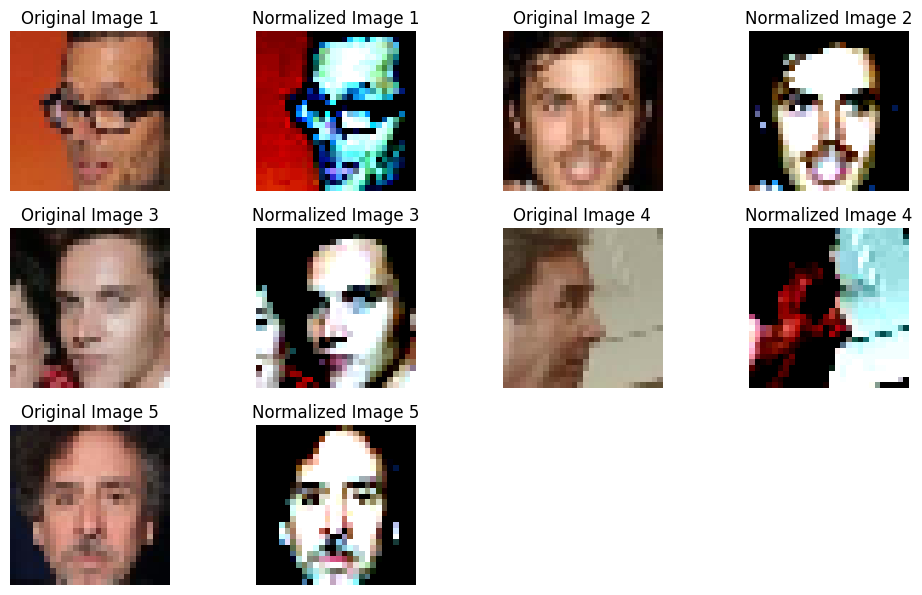

In [ ]:
import matplotlib.pyplot as plt
import random

# Select 10 random indices from the images list
random_indices = random.sample(range(len(images)), 5)

# Create a figure to display the images
plt.figure(figsize=(10, 10))

for i, idx in enumerate(random_indices):
    # Original image (before normalization)
    original_image = images[idx]

    # Normalized image
    normalized_image = normalized_images[idx]

    # Plot original image
    plt.subplot(5, 4, i * 2 + 1)
    plt.imshow(original_image)
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # Plot normalized image
    plt.subplot(5, 4, i * 2 + 2)
    plt.imshow(normalized_image)
    plt.title(f"Normalized Image {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


#VAE

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install tensorflow


In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers


In [ ]:
# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon


class VAELossLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        input_img, decoded, z_mean, z_log_var = inputs
        input_flat = tf.keras.layers.Flatten()(input_img)
        decoded_flat = tf.keras.layers.Flatten()(decoded)
        reconstruction_loss = tf.reduce_mean(tf.square(input_flat - decoded_flat), axis=-1)
        kl_weight = 0.1
        kl_loss = kl_weight * (-0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)
        return decoded

# Function to create VAE model
def create_vae_model(latent_dim, layer_nodes):
    # Encoder
    input_img = tf.keras.Input(shape=(image_shape, image_shape, 3), name="encoder_input")
    x = tf.keras.layers.Flatten()(input_img)
    for nodes in layer_nodes:
        x = tf.keras.layers.Dense(nodes, activation='relu', kernel_initializer='he_normal')(x)
    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

    z = tf.keras.layers.Lambda(sampling, name="z")([z_mean, z_log_var])
    encoder = tf.keras.Model(input_img, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
    x = tf.keras.layers.Dense(layer_nodes[-1], activation='relu', kernel_initializer='he_normal')(latent_inputs)
    for nodes in reversed(layer_nodes[:-1]):
        x = tf.keras.layers.Dense(nodes, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dense(image_shape * image_shape * 3, activation='linear')(x)
    decoded = tf.keras.layers.Reshape((image_shape, image_shape, 3))(x)
    decoder = tf.keras.Model(latent_inputs, decoded, name="decoder")

    # VAE Loss Layer


    # VAE Model
    vae_outputs = decoder(encoder(input_img)[2])  # Use the z (latent space) from encoder
    vae_outputs = VAELossLayer()([input_img, vae_outputs, z_mean, z_log_var])
    vae = tf.keras.Model(input_img, vae_outputs, name="vae")
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0), metrics=[])

    return vae, encoder

In [ ]:

# Define image shape
image_shape = 28  # Adjust this value based on the size of your images (e.g., 28 for MNIST)

# Define parameters
latent_dim = 32
layer_nodes = [512, 256, 128]

# Create the VAE model
vae, encoder = create_vae_model(latent_dim, layer_nodes)

# Summary
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 28, 28, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 2352)           │              0 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 512)            │      1,204,736 │ flatten_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 256)            │        131,328 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Functional)      │ [(None, 32), (None,    │      1,377,216 │ encoder_input[0][0]    │
│                           │ 32), (None, 32)]       │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 128)            │         32,896 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 28, 28, 3)      │      1,375,408 │ encoder[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 32)             │          4,128 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 32)             │          4,128 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vae_loss_layer_2          │ (None, 28, 28, 3)      │              0 │ encoder_input[0][0],   │
│ (VAELossLayer)            │                        │                │ decoder[0][0],         │
│                           │                        │                │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,752,624 (10.50 MB)

 Trainable params: 2,752,624 (10.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs of no improvement
    restore_best_weights=True,  # Restore weights from the best epoch
    verbose=1            # Print early stopping message
)
# Train the VAE
VAE_History = vae.fit(
                        TrainingImages, TrainingImages,
                        epochs=100,
                        batch_size=64 ,
                        validation_data=(ValidationImages, ValidationImages),
                        callbacks=[early_stopping],
                        verbose=1
                     )


Epoch 1/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 21.7233 - val_loss: 22.4119
Epoch 2/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 21.8405 - val_loss: 22.4436
Epoch 3/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 21.7298 - val_loss: 22.3482
Epoch 4/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 21.7168 - val_loss: 22.3847
Epoch 5/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.7044 - val_loss: 22.3544
Epoch 6/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.6038 - val_loss: 22.2938
Epoch 7/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 21.6728 - val_loss: 22.3517
Epoch 8/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.5488 - val_loss: 22.2803
Epoch 9/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.6717 - val_loss: 22.2689
Epoch 10/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 21.5274 - val_loss: 22.2342
Epoch 11/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 21.6286 - val_loss: 22.2820
Epoch 12/100
221/

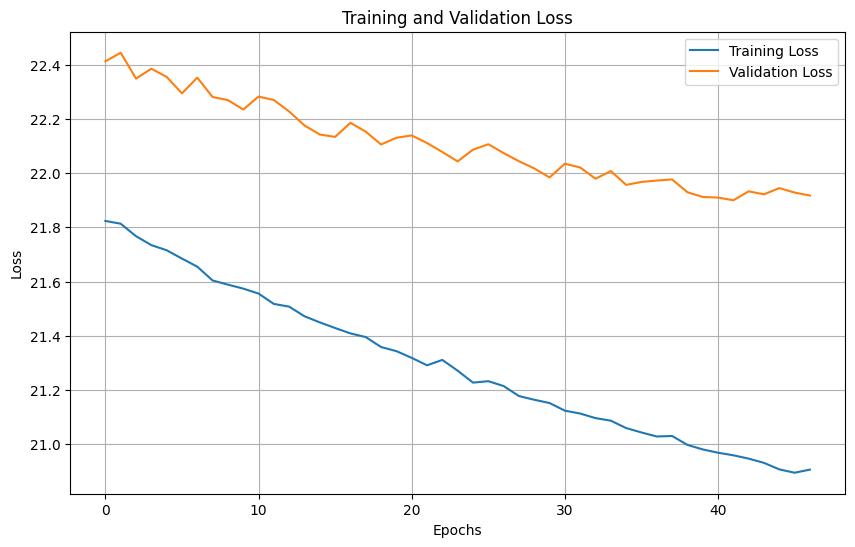

In [ ]:
# Plot the loss after each epoch
plt.figure(figsize=(10, 6))
plt.plot(VAE_History.history['loss'], label='Training Loss')
plt.plot(VAE_History.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#Cross validation for VAE

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Define possible configurations for layer structures
layer_configs = [
    [512, 256, 128],
    [512, 256],
    [1024, 512, 256],
    [1024, 512],
    [256, 128, 64]
]

# Define function to create and compile the VAE model
def create_vae_model(latent_dim, layer_nodes):
    # Encoder
    input_img = tf.keras.Input(shape=(image_shape, image_shape, 3), name="encoder_input")
    x = tf.keras.layers.Flatten()(input_img)
    for nodes in layer_nodes:
        x = tf.keras.layers.Dense(nodes, activation='relu', kernel_initializer='he_normal')(x)
    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

    z = tf.keras.layers.Lambda(sampling, name="z")([z_mean, z_log_var])
    encoder = tf.keras.Model(input_img, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
    x = tf.keras.layers.Dense(layer_nodes[-1], activation='relu', kernel_initializer='he_normal')(latent_inputs)
    for nodes in reversed(layer_nodes[:-1]):
        x = tf.keras.layers.Dense(nodes, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dense(image_shape * image_shape * 3, activation='linear')(x)
    decoded = tf.keras.layers.Reshape((image_shape, image_shape, 3))(x)
    decoder = tf.keras.Model(latent_inputs, decoded, name="decoder")

    vae_outputs = decoder(encoder(input_img)[2])
    vae_outputs = VAELossLayer()([input_img, vae_outputs, z_mean, z_log_var])
    vae = tf.keras.Model(input_img, vae_outputs, name="vae")
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0), metrics=[])

    return vae, encoder

# Define the KFold cross-validation function
def cross_validate(model_configs, X, num_folds=5):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    best_config = None
    best_val_loss = float('inf')

    # Iterate over all model configurations
    for config in model_configs:
        val_losses = []

        # Perform K-fold cross-validation
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]

            vae, encoder = create_vae_model(latent_dim, config)
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

            history = vae.fit(
                X_train, X_train,
                epochs=100,
                batch_size=64,
                validation_data=(X_val, X_val),
                callbacks=[early_stopping],
                verbose=0
            )

            val_loss = min(history.history['val_loss'])  # Use the minimum validation loss from the training
            val_losses.append(val_loss)

        mean_val_loss = np.mean(val_losses)
        print(f"Config {config}: Mean Validation Loss = {mean_val_loss}")

        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            best_config = config

    print(f"Best Configuration: {best_config} with validation loss {best_val_loss}")
    return best_config

# Example usage: assuming `TrainingImages` is your dataset
best_layer_config = cross_validate(layer_configs, TrainingImages)

# Train the model with the best configuration
vae, encoder = create_vae_model(latent_dim, best_layer_config)
vae.fit(
    TrainingImages, TrainingImages,
    epochs=100,
    batch_size=64,
    validation_data=(ValidationImages, ValidationImages),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 42.
Epoch 52: early stopping
Restoring model weights from the end of the best epoch: 47.
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.
Epoch 56: early stopping
Restoring model weights from the end of the best epoch: 51.
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.
Config [512, 256, 128]: Mean Validation Loss = 37.417754364013675
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 37.
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 61.
Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 50.
Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 68.
Epoch 56: early stopping
Restoring model weights from the end of the best epoch: 51.
Config [512, 256]: Mean Validation Loss = 37.384062957763675
Epoch 37: early stoppin

# Euclidean

Epoch 1/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 66.6495 - val_loss: 44.5221
Epoch 2/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 43.2719 - val_loss: 40.5360
Epoch 3/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 40.3547 - val_loss: 39.4966
Epoch 4/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 39.7330 - val_loss: 39.1661
Epoch 5/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 39.2909 - val_loss: 38.8924
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
Evaluating the trained VAE on the test set...
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Mean Squared Error (MSE) on Test Set: 0.6203
Visualizing latent space...
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


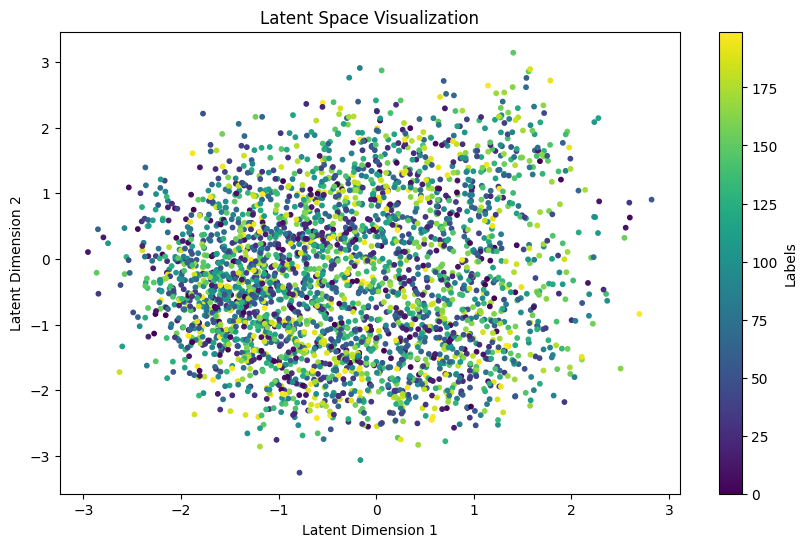

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. **Plot Training and Validation Loss for Cross-Validation**
# This will plot the loss of the model from the cross-validation results to understand how well each configuration performs.
def plot_cross_val_losses(val_losses, model_configs):
    plt.figure(figsize=(10, 6))
    for i, config in enumerate(model_configs):
        plt.plot(val_losses[i], label=f'Config {config}')
    plt.title('Cross-Validation Loss for Different Configurations')
    plt.xlabel('Fold')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# 2. **Test Set Evaluation**: After training with the best configuration, evaluate the model on a separate test set.
def evaluate_model_on_test_set(vae, X_test, y_test):
    # Decode test images
    decoded_images = vae.predict(X_test)

    # Calculate Mean Squared Error (MSE) between the input and the decoded image
    mse = mean_squared_error(X_test.flatten(), decoded_images.flatten())
    print(f"Mean Squared Error (MSE) on Test Set: {mse:.4f}")

    return mse

# 3. **Visualize the Latent Space**: To inspect how well the model learned the data distribution in the latent space.
def visualize_latent_space(encoder, X, y):
    # Use encoder to generate latent space representation (z)
    _, _, z = encoder.predict(X)

    # Visualize latent space with a scatter plot (color-coded by labels)
    plt.figure(figsize=(10, 6))
    plt.scatter(z[:, 0], z[:, 1], c=y, cmap='viridis', s=10)
    plt.title("Latent Space Visualization")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.colorbar(label='Labels')
    plt.show()

# 4. **Train the Model with the Best Configuration from Cross-Validation**
vae, encoder = create_vae_model(latent_dim, best_layer_config)

# Train the model with the best configuration obtained from cross-validation
vae.fit(
    TrainingImages, TrainingImages,
    epochs=100,
    batch_size=64,
    validation_data=(ValidationImages, ValidationImages),
    callbacks=[early_stopping],
    verbose=1
)

# After training, evaluate the model
print("Evaluating the trained VAE on the test set...")
mse = evaluate_model_on_test_set(vae, TestingImages, TestingLabels)

# Optionally, visualize the latent space
print("Visualizing latent space...")
visualize_latent_space(encoder, TestingImages, TestingLabels)
